In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pickle

In [13]:
pipe=pickle.load(open("model.m","rb"))

In [20]:
import math
def predict(df):
    result=pd.DataFrame([],columns=["maxCore","executorInstance","errInTotalTime","errInValTime"])
    for (x,temp) in df.iterrows():
            constant=1.2
            parameterSize=52730*8

            IO=250*1024*1024
            NetIO=(10*1024*1024 if temp["executor_instances"]>1 else IO)
            redOH=9e7#87577296
            couOH=9e7#68973564
            model_parameters=temp[["batchsize","Modelparam_1","Modelparam_2","Modelparam_3","Modelparam_4","Modelparam_5","Modelparam_6","Modelparam_7","Modelparam_8"]]

            executorCores=temp["executor_cores"]
            parallelism=temp["max_core"]
            executorNumber=parallelism/executorCores
            forwardTime=int(pipe.predict([model_parameters])[0][0]/parallelism)
            backwardTime=int(forwardTime*constant)
            getWeightTime=int(parameterSize/NetIO*1e9)
            putGradientTime=int(parameterSize/IO*1e9)
            aggregateGradTime=(executorCores-1)*(parameterSize/NetIO)

            allReduceTime=int((parameterSize/executorNumber)/(NetIO)*1e9)


            #print(forwardTime,temp['forwardTime'],backwardTime,temp['backwardTime'],getWeightTime,temp["GetWeightTime"],putGradientTime,temp["PutGradientTime"],aggregateGradTime,temp["AggregateGradTime"],allReduceTime,
            #     temp["AllReduceNormalized"])

            serials= math.ceil(temp[["max_core"]][0]/temp[["executor_instances"]][0])
            numBatches=math.ceil(temp[["datasize"]][0]/temp[["batchsize"]][0])
            totalTime=numBatches*((forwardTime+backwardTime+getWeightTime+putGradientTime+aggregateGradTime)*serials+redOH+
                                  allReduceTime*serials+couOH)
            validationTime=serials* (((forwardTime/1200)*10000))+3.5e8
           
            result=result.append({"maxCore":temp["max_core"],"executorInstance":temp["executor_instances"],
                                  "errInTotalTime":round((temp["totaltime"]-totalTime)/totalTime*100,2),
                            "errInValTime":round((temp["dataValidationTime"]-validationTime)/validationTime*100,2),
                                 "errInPutTime":round((temp["PutGradientTime"]-putGradientTime)/putGradientTime*100,2),
                                 "errInFWTime":round((temp["forwardTime"]-forwardTime)/forwardTime*100,2),
                                 "errInBWTime":round((temp["backwardTime"]-backwardTime)/backwardTime*100,2),
                                 "errInARTime":round((temp["AllReduceNormalized"]-allReduceTime)/allReduceTime*100,2),}, ignore_index = True)
    return result


In [21]:
df= pd.read_csv("input.csv")
print(df.columns)
result1=predict(df)
result1


Index(['epoch', 'batchsize', 'datasize', 'Modelparam_1', 'Modelparam_2',
       'Modelparam_3', 'Modelparam_4', 'Modelparam_5', 'Modelparam_6',
       'Modelparam_7', 'Modelparam_8', 'max_core', 'driver_core',
       'executor_cores', 'task_cpus', 'executor_instances', 'dataLoadingtime',
       'forwardTime', 'backwardTime', 'lossTime', 'ComputeTime',
       'GetWeightTime', 'PutGradientTime', 'AggregateGradTime',
       'AllReduceNormalized', 'dataValidationTime', 'totaltime'],
      dtype='object')


,maxCore,executorInstance,errInTotalTime,errInValTime,errInARTime,errInBWTime,errInFWTime,errInPutTime
0,1.0,1.0,-6.00,-0.74,39.95,-10.89,-8.08,-0.42
1,2.0,1.0,3.61,4.35,213.59,-4.01,2.56,-5.51
2,3.0,1.0,9.36,15.59,328.29,-2.02,2.82,-2.38
3,4.0,1.0,13.98,12.96,401.69,-2.54,5.34,-7.51
4,5.0,1.0,10.77,10.51,477.25,-5.41,7.63,-3.70
5,2.0,2.0,-7.11,-0.21,-34.27,4.84,14.00,12.89
6,3.0,2.0,-8.37,6.00,-12.64,0.78,9.32,1.92
7,4.0,2.0,-6.58,4.95,19.18,2.57,14.26,6.64
8,5.0,2.0,-4.56,29.03,85.16,1.30,14.59,76.46
9,3.0,3.0,-4.60,4.24,6.69,5.15,13.90,21.31


In [22]:
df= pd.read_csv("input2.csv")
result2=predict(df)
result2

,maxCore,executorInstance,errInTotalTime,errInValTime,errInARTime,errInBWTime,errInFWTime,errInPutTime
0,1.0,1.0,-0.84,2.59,38.55,-6.12,-2.24,300.04
1,2.0,1.0,5.72,4.75,219.05,-0.37,3.96,5.95
2,3.0,1.0,7.82,10.91,313.01,-2.29,3.85,-13.04
3,4.0,1.0,13.74,8.32,405.01,-4.08,4.88,-9.25
4,5.0,1.0,17.74,21.69,464.78,-2.03,10.09,-2.39
5,2.0,2.0,-6.37,-0.16,-33.53,6.11,12.74,17.27
6,3.0,2.0,-7.74,7.40,-12.28,0.38,9.98,6.05
7,4.0,2.0,-5.44,8.10,22.85,2.73,16.10,7.94
8,5.0,2.0,-7.45,26.30,41.46,-0.80,13.09,4.74
9,3.0,3.0,-6.45,3.36,2.53,7.35,16.50,345.61


In [23]:
def nearzero(data):
    dat = data.tolist()
    absolute = [abs(number) for number in dat]
    return dat[absolute.index(min(absolute))]
def abs_min(x):
    tempdf=pd.DataFrame([])
    for t in x:
        
        tempdf=tempdf.append([{t:nearzero(x[t])}])
        
    return tempdf.groupby(level=0).max()

result=pd.concat([result1, result2]).groupby(level=0).apply(abs_min)#.groupby(level=0).apply(min)
result

,,maxCore,executorInstance,errInTotalTime,errInValTime,errInARTime,errInBWTime,errInFWTime,errInPutTime
0,0,1.0,1.0,-0.84,-0.74,38.55,-6.12,-2.24,-0.42
1,0,2.0,1.0,3.61,4.35,213.59,-0.37,2.56,-5.51
2,0,3.0,1.0,7.82,10.91,313.01,-2.02,2.82,-2.38
3,0,4.0,1.0,13.74,8.32,401.69,-2.54,4.88,-7.51
4,0,5.0,1.0,10.77,10.51,464.78,-2.03,7.63,-2.39
5,0,2.0,2.0,-6.37,-0.16,-33.53,4.84,12.74,12.89
6,0,3.0,2.0,-7.74,6.00,-12.28,0.38,9.32,1.92
7,0,4.0,2.0,-5.44,4.95,19.18,2.57,14.26,6.64
8,0,5.0,2.0,-4.56,26.30,41.46,-0.80,13.09,4.74
9,0,3.0,3.0,-4.60,3.36,2.53,5.15,13.90,21.31


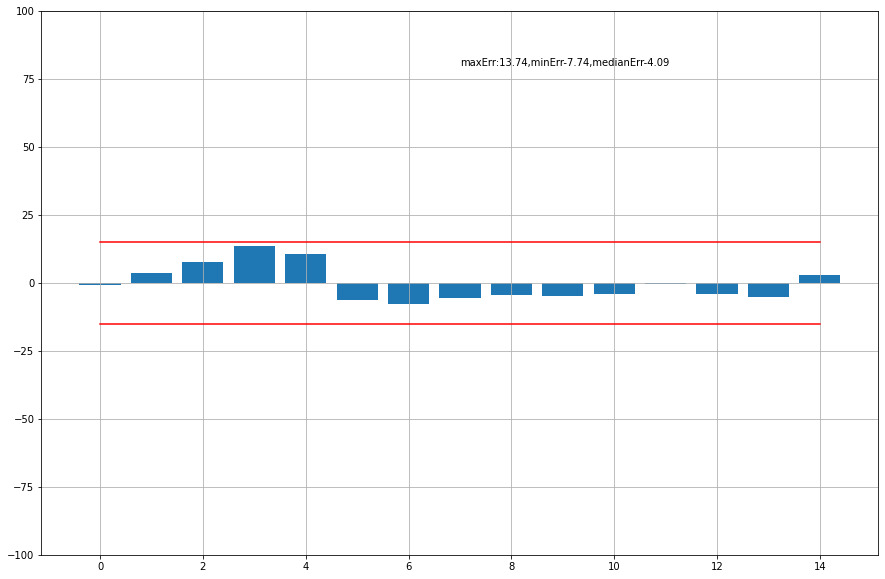

In [31]:
import matplotlib.pyplot as plt
#result.plot(y="errInTotalTime",kind="bar")
#result.xlim(0,100)
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
  
plt.bar(range(15),result["errInTotalTime"])
plt.plot(range(15),[15]*15,color="red")
plt.plot(range(15),[-15]*15,color="red")
plt.ylim(-100,100)
plt.grid(True)
plt.text(7, 80, 'maxErr:{},minErr{},medianErr{}'.format(max(result["errInTotalTime"]),min(result["errInTotalTime"]),result["errInTotalTime"].median()))
plt.show()